In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from sklearn.utils import resample

In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp3.csv')

categorical_cols = ['OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field','stadium','play_type_nfl','roof','surface_type','home_team', 'away_team','season_type']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))
    label_encoders[col] = le  # Save encoders if needed later

Confusion Matrix for fold 1:
[[1060  559]
 [ 991  628]]
Accuracy scores for each fold: [0.5213094502779494, 0.6312538604076591, 0.5407659048795552, 0.4925880172946263, 0.5145151327980235, 0.4978381717109327, 0.5348980852378011, 0.5481778875849289, 0.4848672019765287, 0.5145151327980235, 0.5827671402100062, 0.5311920938851142, 0.535515750463249, 0.49320568252007413, 0.48548486720197653, 0.4928968499073502, 0.5071031500926498, 0.5302655960469426, 0.5960469425571341, 0.4484249536751081, 0.5358245830759728, 0.6355775169857937, 0.4975293390982088, 0.5333539221741815, 0.6080914144533662, 0.43638048177887584, 0.573810994441013, 0.5679431747992588, 0.5531192093885114, 0.4644842495367511, 0.5886349598517604, 0.5873996294008648, 0.4672637430512662, 0.5253242742433601, 0.5472513897467572, 0.5296479308214948, 0.5015441630636195, 0.6235330450895614, 0.5957381099444101, 0.5555898702903026, 0.5398394070413836, 0.5531192093885114, 0.5067943174799259, 0.6040765904879555, 0.5185299567634342, 0.514515132

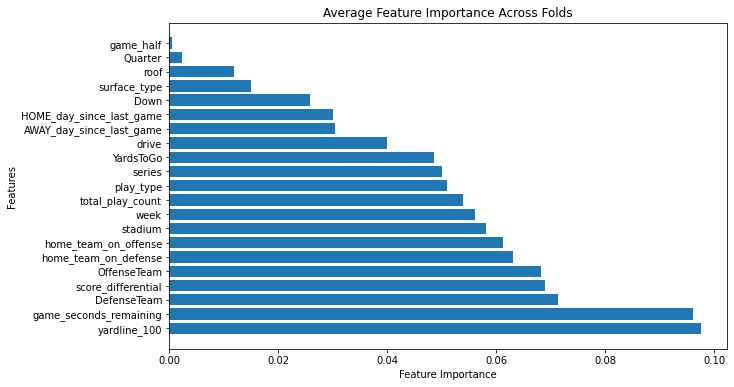

In [ ]:
X = pbp.drop(columns=['Player-Injured-On-Play', 'date','play_id', 'game_id', 'old_game_id',
                            'Description','drive_time_of_possession','num_injuries'])

X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense']]

y = pbp['Player-Injured-On-Play']

k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = []

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]  # Injured plays
    X_train_neg = X_train[y_train == 0]  # Non-injured plays
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # **Resample to ensure 1619 injured and 1619 non-injured plays in training and testing**
    
    # Oversample positive cases (injured plays) if needed
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, 
                                                             replace=True, n_samples=1619, random_state=42)

    # Undersample negative cases (non-injured plays) to 1,522
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, 
                                                             replace=False, n_samples=1619, random_state=42)
    
    # Apply the same strategy to the test set
    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, 
                                                           replace=True, n_samples=1619, random_state=42)
    
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, 
                                                           replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train Decision Tree model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = dt_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Collect feature importances
    feature_importances.append(dt_model.feature_importances_)

    # Compute confusion matrix for the first fold
    if fold == 1:  
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

# Average feature importances over all folds
avg_feature_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(avg_feature_importances)[::-1]  # Sort indices by importance descending
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = avg_feature_importances[sorted_indices]

# Plot feature importances
feature_names = X.columns
plt.figure(figsize=(10, 6), facecolor='white')
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.show()

EXPERIMENT 4

In [4]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp4.csv')

for col in categorical_cols:
    if col in pbp:
        pbp[col] = label_encoders[col].transform(pbp[col].astype(str)) #same label encoding as exp3 

pbp['offense_formation'] = le.fit_transform(pbp['offense_formation'].astype(str)) #encode offensive formation also
label_encoders['offense_formation'] = le

Confusion Matrix for fold 1:
[[1047  572]
 [ 773  846]]
Accuracy scores for each fold: [0.5846201358863496, 0.5960469425571341, 0.5719579987646696, 0.5268684373069796, 0.5216182828906732, 0.567325509573811, 0.46757257566399013, 0.49382334774552195, 0.4746757257566399, 0.5744286596664607, 0.49104385423100677, 0.509573810994441, 0.5697961704756023, 0.5333539221741815, 0.5345892526250772, 0.5111179740580605, 0.5580605311920939, 0.5253242742433601, 0.6003705991352687, 0.5753551575046325, 0.4830142063001853, 0.5735021618282891, 0.4332921556516368, 0.48826436071649165, 0.5719579987646696, 0.48054354539839406, 0.5481778875849289, 0.5731933292155652, 0.5602223594811612, 0.515750463248919, 0.6000617665225447, 0.5438542310067943, 0.5633106856084003, 0.5182211241507103, 0.5055589870290302, 0.5457072266831378, 0.47745521927115503, 0.5626930203829524, 0.5932674490426189, 0.5163681284743669, 0.5938851142680667, 0.55775169857937, 0.4641754169240272, 0.5478690549722051, 0.5892526250772081, 0.487646695

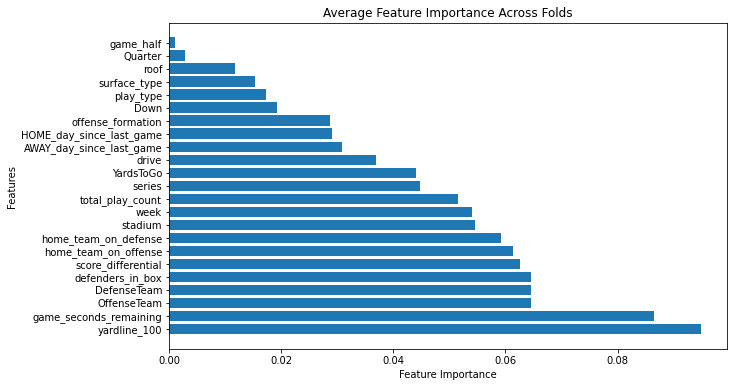

In [ ]:
X = pbp.drop(columns=['Player-Injured-On-Play', 'date','play_id', 'game_id', 'old_game_id',
                            'Description','drive_time_of_possession','num_injuries'])

X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense',
               'defenders_in_box', 'offense_formation']]

y = pbp['Player-Injured-On-Play']

# Define Stratified K-Fold
k = 53  # Number of splits
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
feature_importances = []

# Perform stratified K-Fold cross-validation
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]  # Injured plays
    X_train_neg = X_train[y_train == 0]  # Non-injured plays
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    
    # Oversample positive cases 
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, 
                                                             replace=True, n_samples=1619, random_state=42)

    # Undersample negative cases 
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, 
                                                             replace=False, n_samples=1619, random_state=42)
    
    # Apply the same strategy to the test set
    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, 
                                                           replace=True, n_samples=1619, random_state=42)
    
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, 
                                                           replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train Decision Tree model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict & Evaluate
    y_pred = dt_model.predict(X_test_resampled)
    accuracy = accuracy_score(y_test_resampled, y_pred)
    precision = precision_score(y_test_resampled, y_pred)
    recall = recall_score(y_test_resampled, y_pred)

    # Append results to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Collect feature importances
    feature_importances.append(dt_model.feature_importances_)

    # Compute confusion matrix for the first fold
    if fold == 1:  
        cm = confusion_matrix(y_test_resampled, y_pred)
        print(f'Confusion Matrix for fold {fold}:')
        print(cm)

# Print cross-validation results
print(f'Accuracy scores for each fold: {accuracy_scores}')
print(f'Mean Accuracy: {np.mean(accuracy_scores):.4f}')
print(f'Standard Deviation: {np.std(accuracy_scores):.4f}')

print(f'Precision scores for each fold: {precision_scores}')
print(f'Mean Precision: {np.mean(precision_scores):.4f}')
print(f'Standard Deviation: {np.std(precision_scores):.4f}')

print(f'Recall scores for each fold: {recall_scores}')
print(f'Mean Recall: {np.mean(recall_scores):.4f}')
print(f'Standard Deviation: {np.std(recall_scores):.4f}')

# Average feature importances over all folds
avg_feature_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(avg_feature_importances)[::-1]  # Sort indices by importance descending
sorted_feature_names = X.columns[sorted_indices]
sorted_importances = avg_feature_importances[sorted_indices]

# Plot feature importances
feature_names = X.columns
plt.figure(figsize=(10, 6), facecolor='white')
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance Across Folds')
plt.show()